In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import sys


warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False
sys.path.append(str(Path.cwd()))

# 設定硬體
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {DEVICE}")

current_dir = Path.cwd()

# 取得上一層目錄 (專案根目錄，例如 D:\NCKU\paper4)
project_root = current_dir.parent

# 把根目錄加入 Python 的搜尋路徑
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    print(f"已加入專案路徑: {project_root}")

import src.utils.helpers as helpers
helpers.set_seed(42)

Running on: cuda
Seed set to: 42 (Deterministic mode ON)


In [9]:
# ==============================================================================
# 🔴 [USER INPUT] 請在此填入您 Ablation Study 中表現最好的數據
# ==============================================================================
MY_MODEL_NAME = "E2E-ALR (Ours)"

# 請根據您的實驗結果修改這些數值
MY_R2 = 0.8046
MY_RMSE = 1.5639
MY_AVG_ACC = 0.7263  # 保留這個 (平均準確率)
MY_H_ACC = 0.9021  # 保留這個 (高波動準確率)

# 路徑設定
current_dir = Path.cwd()
dataset_path = current_dir.parent / "dataset" / "USD_TWD.csv"

if not dataset_path.exists():
    print(f"[Error] 找不到資料集: {dataset_path}")
else:
    print(f"資料集路徑確認: {dataset_path}")

資料集路徑確認: d:\NCKU\paper4\dataset\USD_TWD.csv


In [10]:
LOOKBACK = 30
HORIZON = 3


def prepare_data_comparison(df):
    df = df.copy()
    vol_window = 7
    df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Volatility"] = df["log_return"].rolling(vol_window).std() * np.sqrt(252) * 100

    # 技術指標 (Baseline 常用的)
    df["RSI"] = df["log_return"].rolling(14).mean().fillna(0)
    exp1 = df['Close'].ewm(span=12).mean()
    exp2 = df['Close'].ewm(span=26).mean()
    df['MACD'] = exp1 - exp2
    sma = df['Close'].rolling(20).mean()
    std = df['Close'].rolling(20).std()
    df['BB_Width'] = ((sma + std * 2) - (sma - std * 2)) / sma

    df = df.dropna().reset_index(drop=True)

    raw_cols = ["Volatility", "log_return"]
    full_cols = ["Volatility", "log_return", "RSI", "MACD", "BB_Width"]

    split_idx = int(len(df) * 0.8)

    scaler_raw = StandardScaler()
    data_raw = scaler_raw.fit_transform(df[raw_cols].values)

    scaler_full = StandardScaler()
    data_full = scaler_full.fit_transform(df[full_cols].values)

    target_scaler = StandardScaler()
    target_scaler.fit(df["Volatility"].values[:split_idx].reshape(-1, 1))

    def create_seq(data, label_data):
        X, y = [], []
        for i in range(len(data) - LOOKBACK - HORIZON + 1):
            X.append(data[i:i + LOOKBACK])
            y.append(label_data[i + LOOKBACK: i + LOOKBACK + HORIZON])
        return np.array(X), np.array(y)

    y_labels = data_raw[:, 0]

    X_raw, y_all = create_seq(data_raw, y_labels)
    X_tr_r, X_te_r = X_raw[:split_idx], X_raw[split_idx:]
    y_tr, y_te = y_all[:split_idx], y_all[split_idx:]

    X_full, _ = create_seq(data_full, y_labels)
    X_tr_f, X_te_f = X_full[:split_idx], X_full[split_idx:]

    return (X_tr_r, X_te_r), (X_tr_f, X_te_f), y_tr, y_te, target_scaler


# 載入資料
df_raw = pd.read_csv(dataset_path)
(X_tr_r, X_te_r), (X_tr_f, X_te_f), y_tr, y_te, scaler = prepare_data_comparison(df_raw)

# 攤平資料供 ML 模型使用
X_tr_r_flat = X_tr_r.reshape(X_tr_r.shape[0], -1)
X_te_r_flat = X_te_r.reshape(X_te_r.shape[0], -1)
X_tr_f_flat = X_tr_f.reshape(X_tr_f.shape[0], -1)
X_te_f_flat = X_te_f.reshape(X_te_f.shape[0], -1)

print(f"Data Ready. Train Size: {len(X_tr_r)}, Test Size: {len(X_te_r)}")

Data Ready. Train Size: 5375, Test Size: 1312


In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, num_layers=2, output_dim=HORIZON):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class SimpleTransformer(nn.Module):
    def __init__(self, input_dim=2, d_model=32, nhead=2, num_layers=1, output_dim=HORIZON):
        super(SimpleTransformer, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=64, dropout=0.1,
                                                   batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, output_dim)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.transformer_encoder(x)
        return self.fc(x[:, -1, :])

In [12]:
def train_dl_model(model, X_train, y_train, epochs=60, lr=0.001):
    model = model.to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    model.train()
    for _ in range(epochs):
        for bx, by in loader:
            bx, by = bx.to(DEVICE), by.to(DEVICE)
            optimizer.zero_grad()
            out = model(bx)
            loss = criterion(out, by)
            loss.backward()
            optimizer.step()
    return model


def predict_dl(model, X_test):
    model.eval()
    with torch.no_grad():
        inputs = torch.FloatTensor(X_test).to(DEVICE)
        preds = model(inputs)
    return preds.cpu().numpy()


def get_metrics_detailed(targets, preds, last_knowns):
    # targets, preds: (N, 3)
    # last_knowns: (N, 1)

    if last_knowns.ndim == 1:
        last_knowns = last_knowns.reshape(-1, 1)

    # R2 & RMSE
    r2 = r2_score(targets.flatten(), preds.flatten())
    rmse = np.sqrt(mean_squared_error(targets.flatten(), preds.flatten()))

    # Direction Accuracy Matrix
    true_delta = targets - last_knowns
    pred_delta = preds - last_knowns
    dir_correct = (np.sign(true_delta) == np.sign(pred_delta))

    # 1. Average Acc
    acc_avg = np.mean(dir_correct)

    # 2. Step-wise Acc
    acc_steps = np.mean(dir_correct, axis=0)

    # 3. High Vol Acc
    magnitude = np.abs(true_delta)
    thresh = np.percentile(magnitude, 80)
    high_vol_mask = magnitude > thresh
    h_acc = np.mean(dir_correct[high_vol_mask]) if np.sum(high_vol_mask) > 0 else 0

    return r2, rmse, acc_avg, acc_steps, h_acc

In [13]:
def inv_seq(d):
    N, H = d.shape
    flat = d.reshape(-1, 1)
    inv_flat = scaler.inverse_transform(flat)
    return inv_flat.reshape(N, H)


def inv_anchor(d):
    return scaler.inverse_transform(d.reshape(-1, 1))


y_true = inv_seq(y_te)
last_known = inv_anchor(X_te_r[:, -1, 0])

results = []

# --- 1. Statistical Baselines ---
print("Running Stats Models...")

# Naive
y_naive = np.repeat(last_known, HORIZON, axis=1)
metrics = get_metrics_detailed(y_true, y_naive, last_known)
# 修改點：只取 metrics[0,1,2,4]，跳過 metrics[3] (Day-wise)
results.append(["Naive", "Stats", metrics[0], metrics[1], metrics[2], metrics[4]])

# SMA
sma = np.mean(X_te_r[:, :, 0], axis=1).reshape(-1, 1)
sma_seq = np.repeat(scaler.inverse_transform(sma), HORIZON, axis=1)
metrics = get_metrics_detailed(y_true, sma_seq, last_known)
results.append(["SMA", "Stats", metrics[0], metrics[1], metrics[2], metrics[4]])

# Linear Regression
lr = LinearRegression()
lr.fit(X_tr_r_flat, y_tr)
y_pred = inv_seq(lr.predict(X_te_r_flat))
metrics = get_metrics_detailed(y_true, y_pred, last_known)
results.append(["Linear Reg", "Stats", metrics[0], metrics[1], metrics[2], metrics[4]])

# --- 2. Machine Learning ---
print("Running ML Models...")

# SVR
svr = MultiOutputRegressor(SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1))
svr.fit(X_tr_f_flat, y_tr)
y_pred = inv_seq(svr.predict(X_te_f_flat))
metrics = get_metrics_detailed(y_true, y_pred, last_known)
results.append(["SVR (RBF)", "ML", metrics[0], metrics[1], metrics[2], metrics[4]])

# Random Forest
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_tr_f_flat, y_tr)
y_pred = inv_seq(rf.predict(X_te_f_flat))
metrics = get_metrics_detailed(y_true, y_pred, last_known)
results.append(["Random Forest", "ML", metrics[0], metrics[1], metrics[2], metrics[4]])

# XGBoost
xgb_m = xgb.XGBRegressor(n_estimators=100, n_jobs=-1, random_state=42)
xgb_m.fit(X_tr_f_flat, y_tr)
y_pred = inv_seq(xgb_m.predict(X_te_f_flat))
metrics = get_metrics_detailed(y_true, y_pred, last_known)
results.append(["XGBoost", "ML", metrics[0], metrics[1], metrics[2], metrics[4]])

# --- 3. Deep Learning ---
print("Running DL Models...")

# LSTM
lstm = LSTMModel(input_dim=2, output_dim=HORIZON)
lstm = train_dl_model(lstm, X_tr_r, y_tr)
y_pred = inv_seq(predict_dl(lstm, X_te_r))
metrics = get_metrics_detailed(y_true, y_pred, last_known)
results.append(["LSTM", "DL", metrics[0], metrics[1], metrics[2], metrics[4]])

# Transformer
tf = SimpleTransformer(input_dim=2, output_dim=HORIZON)
tf = train_dl_model(tf, X_tr_r, y_tr)
y_pred = inv_seq(predict_dl(tf, X_te_r))
metrics = get_metrics_detailed(y_true, y_pred, last_known)
results.append(["Transformer", "DL", metrics[0], metrics[1], metrics[2], metrics[4]])

# --- 4. OUR CHAMPION (From User Input) ---
# 修改點：只加入 Avg Acc 和 High Vol Acc
results.append([MY_MODEL_NAME, "Ours", MY_R2, MY_RMSE, MY_AVG_ACC, MY_H_ACC])

print("Benchmark Completed.")

Running Stats Models...
Running ML Models...
Running DL Models...
Benchmark Completed.



🏆 GRAND UNIFIED BENCHMARK: Sequence Forecast Breakdown 🏆


,Model,Type,R2,RMSE,Avg Acc,High Vol Acc
8,E2E-ALR (Ours),Ours,0.804600,1.563900,0.726300,0.902100
4,Random Forest,ML,0.427178,2.372275,0.654217,0.838628
5,XGBoost,ML,0.410370,2.406827,0.680894,0.834816
6,LSTM,DL,0.418475,2.390227,0.642276,0.776366
2,Linear Reg,Stats,0.749120,1.569958,0.638974,0.773825
3,SVR (RBF),ML,0.059567,3.039618,0.589939,0.761118
7,Transformer,DL,0.416204,2.394891,0.602896,0.734435
1,SMA,Stats,0.016175,3.108951,0.558689,0.712834
0,Naive,Stats,0.636063,1.890898,0.000000,0.000000


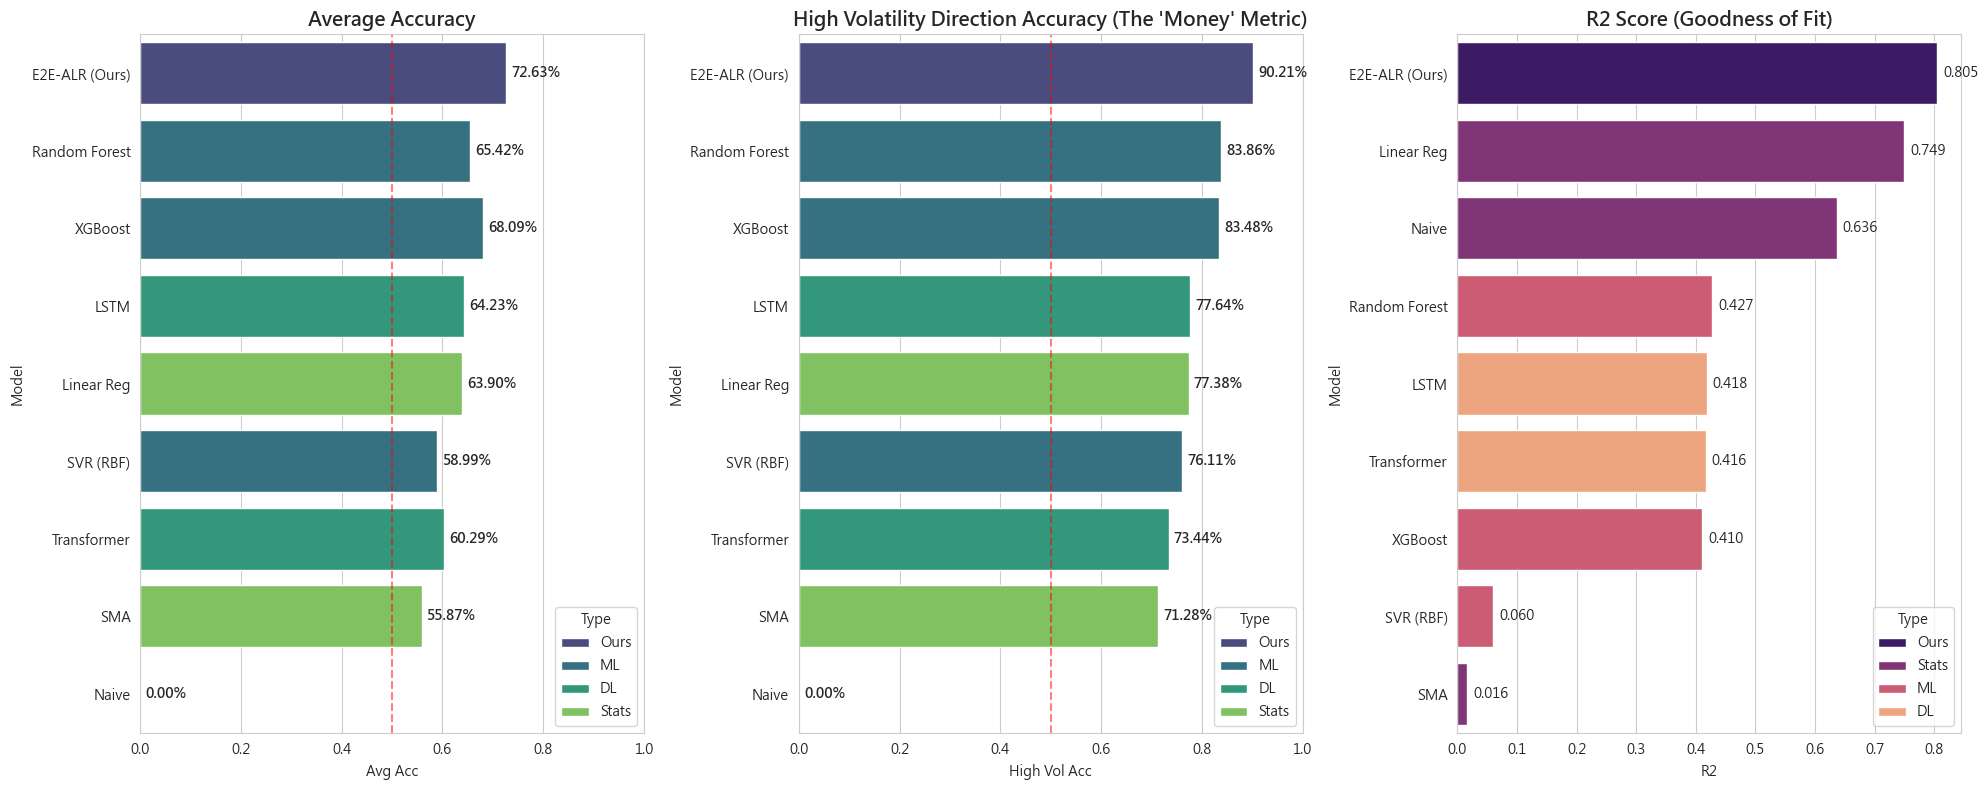

In [21]:
# 修改點：移除 "Day1", "Day2", "Day3"
cols = ["Model", "Type", "R2", "RMSE", "Avg Acc", "High Vol Acc"]
res_df = pd.DataFrame(results, columns=cols).sort_values(by="High Vol Acc", ascending=False)

print("\n" + "=" * 100)
print("🏆 GRAND UNIFIED BENCHMARK: Sequence Forecast Breakdown 🏆")
print("=" * 100)
display(res_df.style.highlight_max(axis=0, color='lightgreen', subset=["R2", "Avg Acc", "High Vol Acc"]).highlight_min(
    axis=0, color='lightgreen', subset=["RMSE"]))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Chart 1: Avg Accuracy
sns.barplot(data=res_df, y="Model", x="Avg Acc", hue="Type", dodge=False, ax=axes[0], palette="viridis")
axes[0].set_title("Average Accuracy", fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 1.0)
axes[0].axvline(0.5, color='r', linestyle='--', alpha=0.5)

for i, v in enumerate(res_df["Avg Acc"]):
    axes[0].text(v + 0.01, i, f"{v:.2%}", va='center', fontweight='bold')

# Chart 1: High Volatility Accuracy
sns.barplot(data=res_df, y="Model", x="High Vol Acc", hue="Type", dodge=False, ax=axes[1], palette="viridis")
axes[1].set_title("High Volatility Direction Accuracy (The 'Money' Metric)", fontsize=14, fontweight='bold')
axes[1].set_xlim(0, 1.0)
axes[1].axvline(0.5, color='r', linestyle='--', alpha=0.5)

for i, v in enumerate(res_df["High Vol Acc"]):
    axes[1].text(v + 0.01, i, f"{v:.2%}", va='center', fontweight='bold')

# Chart 2: R2 Score
res_df_r2 = res_df.sort_values(by="R2", ascending=False)
sns.barplot(data=res_df_r2, y="Model", x="R2", hue="Type", dodge=False, ax=axes[2], palette="magma")
axes[2].set_title("R2 Score (Goodness of Fit)", fontsize=14, fontweight='bold')

for i, v in enumerate(res_df_r2["R2"]):
    axes[2].text(v + 0.01, i, f"{v:.3f}", va='center')

plt.tight_layout()
plt.show()

# Save
res_df.to_csv("benchmark_results.csv", index=False)